# **TikTok Classification Project**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
data = pd.read_csv("tiktok_dataset.csv")

In [3]:
data.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [5]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [6]:
data['claim_status'].value_counts()

claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

In [7]:
claims = data[data['claim_status'] == 'claim']
print('Mean view count claims:', claims['video_view_count'].mean())
print('Median view count claims:', claims['video_view_count'].median())

Mean view count claims: 501029.4527477102
Median view count claims: 501555.0


In [8]:
opinions = data[data['claim_status'] == 'opinion']
print('Mean view count opinions:', opinions['video_view_count'].mean())
print('Median view count opinions:', opinions['video_view_count'].median())

Mean view count opinions: 4956.43224989447
Median view count opinions: 4953.0


In [9]:
data.groupby(['claim_status', 'author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

In [10]:
data.groupby(['author_ban_status']).agg(
    {'video_view_count': ['mean', 'median'],
     'video_like_count': ['mean', 'median'],
     'video_share_count': ['mean', 'median']})

video_view_count           video_like_count            \
                              mean    median             mean    median   
author_ban_status                                                         
active               215927.039524    8616.0     71036.533836    2222.0   
banned               445845.439144  448201.0    153017.236697  105573.0   
under review         392204.836399  365245.5    128718.050339   71204.5   

                  video_share_count           
                               mean   median  
author_ban_status                             
active                 14111.466164    437.0  
banned                 29998.942508  14468.0  
under review           25774.696999   9444.0

In [11]:
data.groupby(['author_ban_status']).median(numeric_only=True)[
    ['video_share_count']]

,video_share_count
author_ban_status,
active,437.0
banned,14468.0
under review,9444.0


In [12]:
data.groupby(['author_ban_status']).agg(
    {
        'video_view_count' : ['count','mean','median'],
        'video_like_count' : ['count','mean','median'],
        'video_share_count' : ['count','mean','median']
    }
)

video_view_count                          video_like_count  \
                             count           mean    median            count   
author_ban_status                                                              
active                       15383  215927.039524    8616.0            15383   
banned                        1635  445845.439144  448201.0             1635   
under review                  2066  392204.836399  365245.5             2066   

                                           video_share_count                \
                            mean    median             count          mean   
author_ban_status                                                            
active              71036.533836    2222.0             15383  14111.466164   
banned             153017.236697  105573.0              1635  29998.942508   
under review       128718.050339   71204.5              2066  25774.696999   

                            
                    median  
author_ban_status           
active               437.0  
banned             14468.0  
under review        9444.0

In [13]:
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['shares_per_view'] = data['video_share_count'] / data['video_view_count']

In [14]:
data.groupby(['claim_status', 'author_ban_status']).agg(
    {'likes_per_view': ['count', 'mean', 'median'],
     'comments_per_view': ['count', 'mean', 'median'],
     'shares_per_view': ['count', 'mean', 'median']})

likes_per_view                      \
                                        count      mean    median   
claim_status author_ban_status                                      
claim        active                      6566  0.329542  0.326538   
             banned                      1439  0.345071  0.358909   
             under review                1603  0.327997  0.320867   
opinion      active                      8817  0.219744  0.218330   
             banned                       196  0.206868  0.198483   
             under review                 463  0.226394  0.228051   

                               comments_per_view                      \
                                           count      mean    median   
claim_status author_ban_status                                         
claim        active                         6566  0.001393  0.000776   
             banned                         1439  0.001377  0.000746   
             under review                   1603  0.001367  0.000789   
opinion      active                         8817  0.000517  0.000252   
             banned                          196  0.000434  0.000193   
             under review                    463  0.000536  0.000293   

                               shares_per_view                      
                                         count      mean    median  
claim_status author_ban_status                                      
claim        active                       6566  0.065456  0.049279  
             banned                       1439  0.067893  0.051606  
             under review                 1603  0.065733  0.049967  
opinion      active                       8817  0.043729  0.032405  
             banned                        196  0.040531  0.030728  
             under review                  463  0.044472  0.035027

<Axes: title={'center': 'Video_duration_sec'}, xlabel='video_duration_sec'>

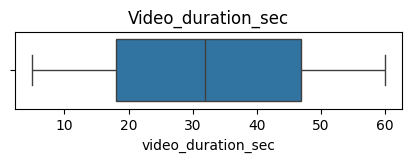

In [15]:
plt.figure(figsize=(5,1))
plt.title('Video_duration_sec')
sns.boxplot(x=data['video_duration_sec'])

Text(0.5, 1.0, 'Video duration histogram')

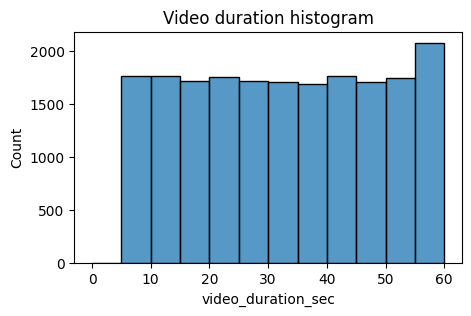

In [16]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_duration_sec'], bins = range(0,61,5))
plt.title('Video duration histogram')

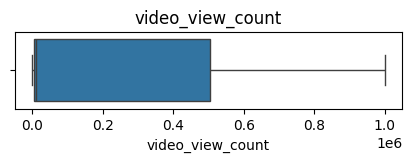

In [17]:
plt.figure(figsize=(5, 1))
plt.title('video_view_count')
sns.boxplot(x=data['video_view_count']);

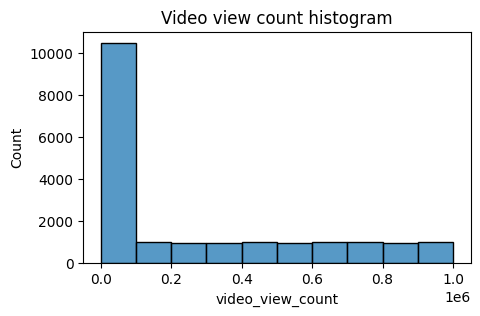

In [18]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_view_count'], bins=range(0,(10**6+1),10**5))
plt.title('Video view count histogram');

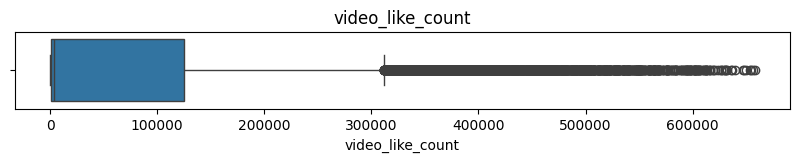

In [19]:
plt.figure(figsize=(10,1))
plt.title('video_like_count')
sns.boxplot(x=data['video_like_count']);

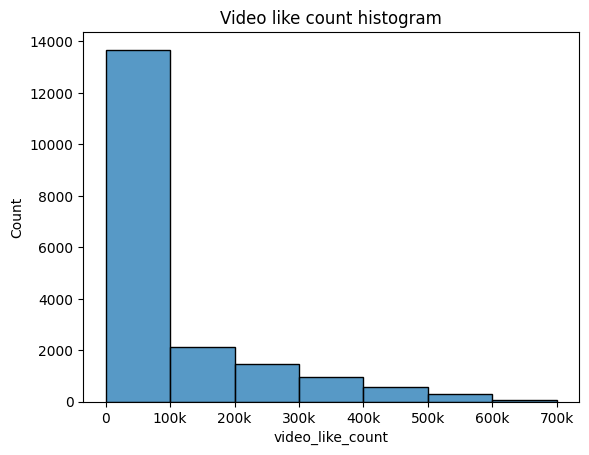

In [20]:
ax = sns.histplot(data['video_like_count'], bins=range(0,(7*10**5+1),10**5))
labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]
ax.set_xticks(range(0,7*10**5+1,10**5), labels=labels)
plt.title('Video like count histogram');

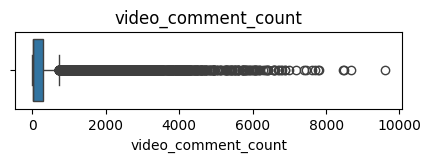

In [21]:
plt.figure(figsize=(5,1))
plt.title('video_comment_count')
sns.boxplot(x=data['video_comment_count']);

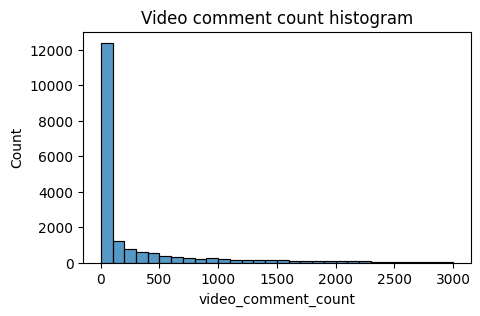

In [22]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

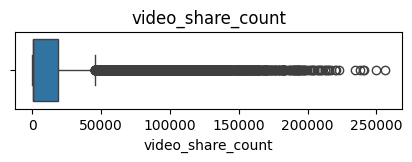

In [23]:
plt.figure(figsize=(5,1))
plt.title('video_share_count')
sns.boxplot(x=data['video_share_count']);

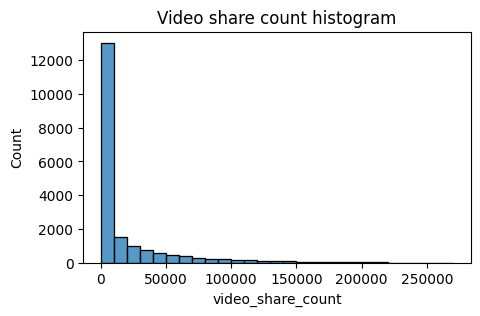

In [24]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_share_count'], bins=range(0,(270001),10000))
plt.title('Video share count histogram');

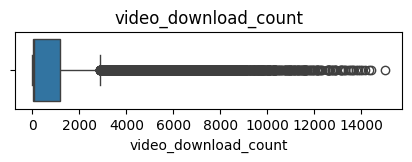

In [25]:
plt.figure(figsize=(5,1))
plt.title('video_download_count')
sns.boxplot(x=data['video_download_count']);

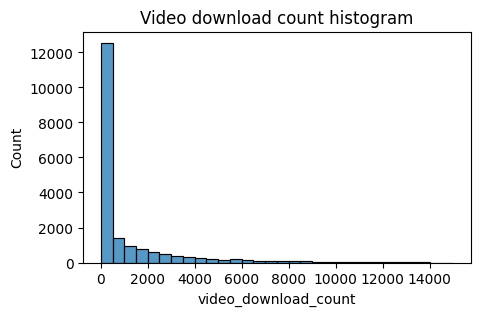

In [26]:
plt.figure(figsize=(5,3))
sns.histplot(data['video_download_count'], bins=range(0,(15001),500))
plt.title('Video download count histogram');

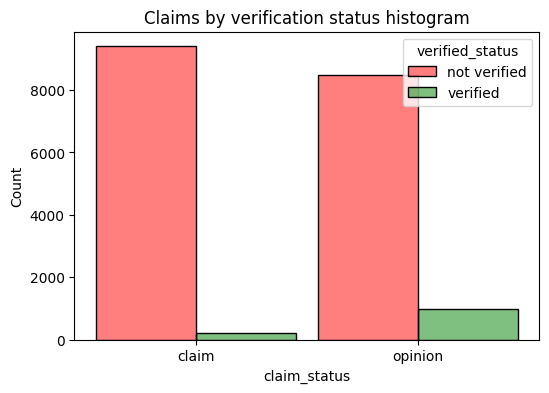

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(data=data,
             x='claim_status',
             hue='verified_status',
             multiple='dodge',
             palette={'not verified':'red','verified':'green'},
             shrink=0.9, alpha = 0.5)
plt.title('Claims by verification status histogram');

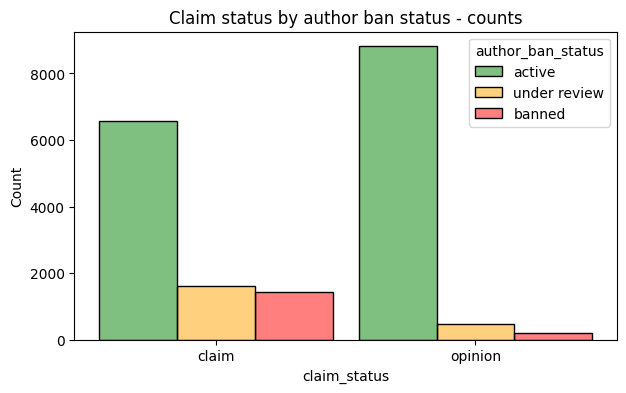

In [28]:
fig = plt.figure(figsize=(7,4))
sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');

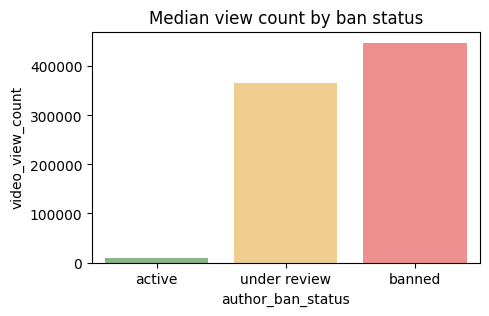

In [29]:
ban_status_counts = data.groupby(['author_ban_status']).median(
    numeric_only=True).reset_index()

fig = plt.figure(figsize=(5,3))
sns.barplot(data=ban_status_counts,
            x='author_ban_status',
            y='video_view_count',
            hue = 'author_ban_status',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)
plt.title('Median view count by ban status');

In [30]:
data.groupby('claim_status')['video_view_count'].median()

claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

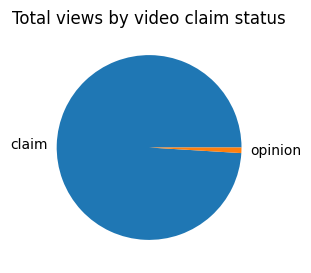

In [31]:
fig = plt.figure(figsize=(3,3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

In [32]:
count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
              ]

for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    median = data[column].median()
    outlier_threshold = median + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (data[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_view_count: 2343
Number of outliers, video_like_count: 3468
Number of outliers, video_share_count: 3732
Number of outliers, video_download_count: 3733
Number of outliers, video_comment_count: 3882


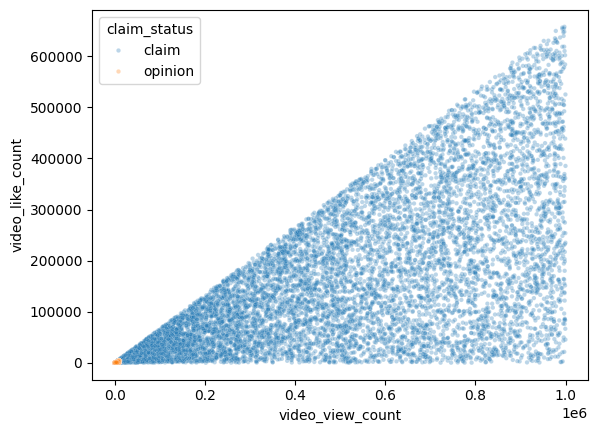

In [33]:
sns.scatterplot(x=data["video_view_count"], y=data["video_like_count"],
                hue=data["claim_status"], s=10, alpha=.3)
plt.show()

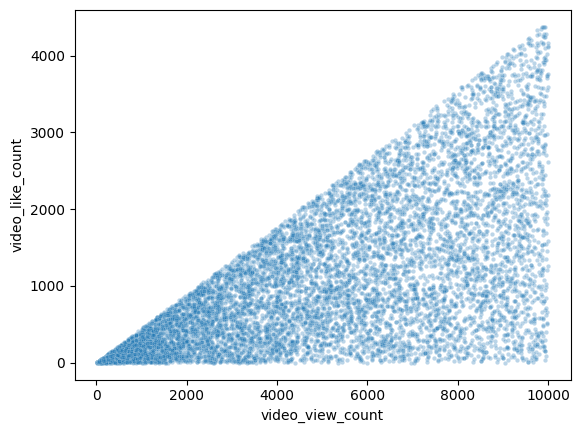

In [34]:
opinion = data[data['claim_status']=='opinion']
sns.scatterplot(x=opinion["video_view_count"], y=opinion["video_like_count"],
                 s=10, alpha=.3)
plt.show()

In [35]:
data = data.dropna(axis=0)

not_verified = data[data["verified_status"] == "not verified"]["video_view_count"]
verified = data[data["verified_status"] == "verified"]["video_view_count"]

stats.ttest_ind(a=not_verified, b=verified, equal_var=False)

TtestResult(statistic=25.499441780633777, pvalue=2.6088823687177823e-120, df=1571.163074387424)

In [36]:
percentile25 = data["video_like_count"].quantile(0.25)
percentile75 = data["video_like_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_like_count"] > upper_limit, "video_like_count"] = upper_limit


In [37]:
percentile25 = data["video_comment_count"].quantile(0.25)
percentile75 = data["video_comment_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

In [38]:
data["verified_status"].value_counts(normalize=True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

In [39]:
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results


data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

data_upsampled["verified_status"].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

In [40]:
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))


,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


In [41]:
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

In [42]:
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


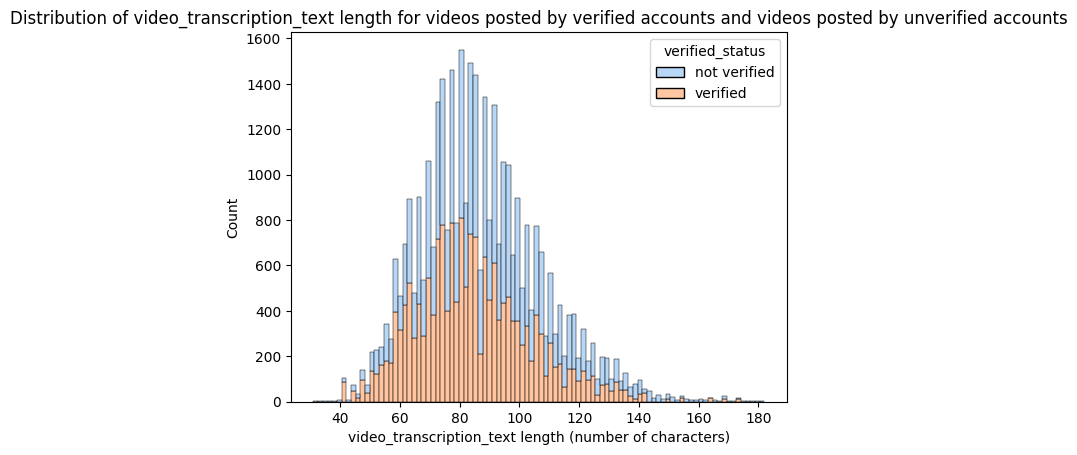

In [43]:
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

In [44]:
data_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.282755,-0.311144,-0.214349,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.005539,0.005954,-0.001698,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.003731,-0.021063,0.001244,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.278638,0.292290,0.204884,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.565200,0.442375,0.404021,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.485643,0.389892,0.594859,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.476817,0.600509,0.343180,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.455890,0.634753,0.332204,0.217661
likes_per_view,-0.282755,-0.005539,-0.003731,0.278638,0.565200,0.485643,0.476817,0.455890,1.000000,0.539845,0.675187,0.094428
comments_per_view,-0.311144,0.005954,-0.021063,0.292290,0.442375,0.389892,0.600509,0.634753,0.539845,1.000000,0.394044,0.114497


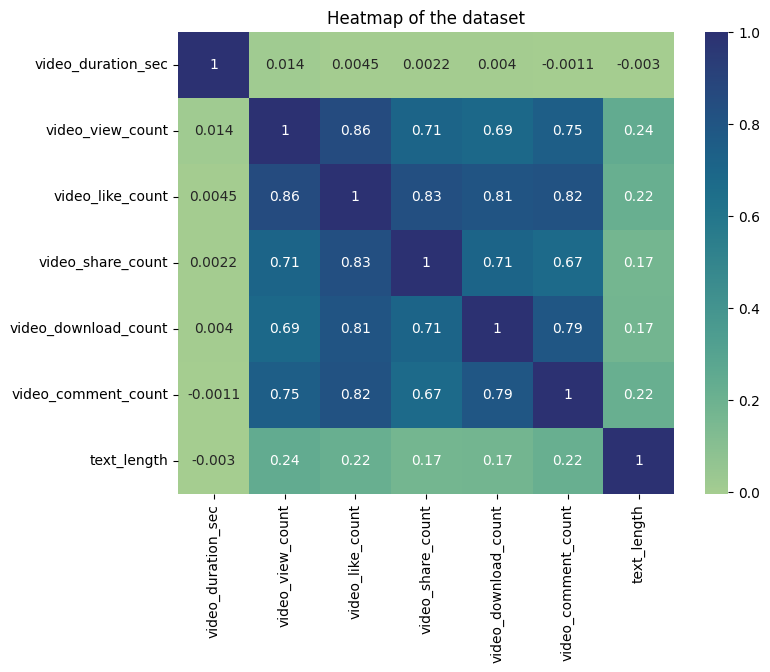

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

### **Logistic Regression model**

In [46]:
y = data_upsampled["verified_status"]

In [47]:
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]
X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

In [49]:
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [50]:
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

In [51]:
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]
X_train_to_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [52]:
X_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [53]:
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [54]:
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [55]:
X_train.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,2252.0,23.0,4.0,0.0
20491,52,6664.0,550.0,53.0,2.0
25583,37,6327.0,257.0,3.0,0.0
18474,57,1702.0,28.0,0.0,0.0
27312,21,3842.0,101.0,1.0,0.0


In [56]:
X_train_final = pd.concat([X_train.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_train_encoded_df], axis=1)


In [57]:
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


In [58]:
y_train.dtype

dtype('O')

In [59]:
y_train.unique()

array(['verified', 'not verified'], dtype=object)

In [60]:
y_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [62]:
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

In [64]:
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)

In [65]:
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]
X_test_to_encode.head()

,claim_status,author_ban_status
21061,opinion,active
31748,opinion,active
20197,claim,active
5727,claim,active
11607,opinion,active


In [66]:
X_test_encoded = X_encoder.transform(X_test_to_encode)
X_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [67]:
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())
X_test_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [68]:
X_test.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
21061,41,2118.0,57.0,5.0,2.0
31748,27,5701.0,157.0,1.0,0.0
20197,31,449767.0,75385.0,5956.0,728.5
5727,19,792813.0,56597.0,5146.0,728.5
11607,54,2044.0,68.0,19.0,2.0


In [69]:
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


In [70]:
y_pred = log_clf.predict(X_test_final)

In [71]:
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

In [72]:
y_test

21061        verified
31748        verified
20197        verified
5727     not verified
11607    not verified
             ...     
14756    not verified
26564        verified
14800    not verified
35705        verified
31060        verified
Name: verified_status, Length: 8942, dtype: object

In [73]:
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

In [74]:
X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape

((26826, 8), (26826,), (8942, 8), (8942,))

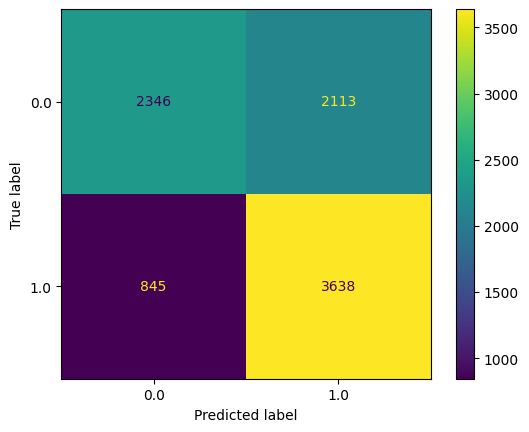

In [75]:
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
log_disp.plot()
plt.show()


In [86]:
accuracy = (3638+2346)/ (3638+845+2113+2346)
accuracy

0.6692015209125475

In [78]:
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.53      0.61      4459
not verified       0.63      0.81      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.68      0.67      0.66      8942
weighted avg       0.68      0.67      0.66      8942



In [79]:
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,-3.308494e-03
1,video_view_count,-3.478850e-07
2,video_share_count,4.979665e-06
3,video_download_count,-7.223523e-05
4,video_comment_count,3.325829e-04
5,claim_status_opinion,1.515372e+00
6,author_ban_status_banned,-5.726036e-01
7,author_ban_status_under review,-4.232512e-01


In [82]:
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128


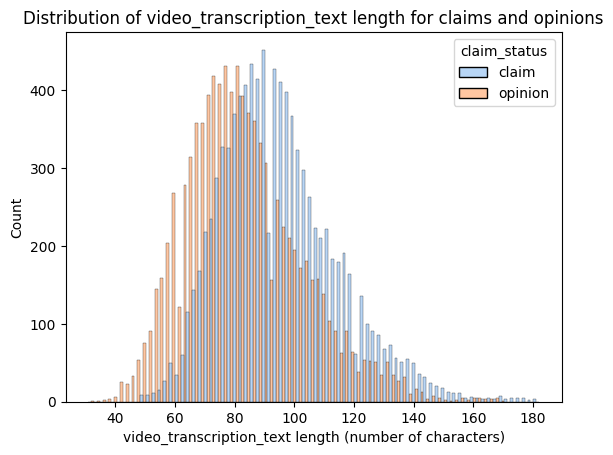

In [83]:
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

In [85]:
X = data.copy()
X = X.drop(['#', 'video_id'], axis=1)
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
X = pd.get_dummies(X,columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

C:\Users\Sudev Sudhish\AppData\Local\Temp\ipykernel_11288\3261524630.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})


,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,0.548459,0.001335,0.079569,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,0.622910,0.002706,0.073175,128,False,False,False


In [87]:
y = X['claim_status']
X = X.drop(['claim_status'], axis=1)

In [89]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

In [90]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 14), (3817, 14), (3817, 14), (11450,), (3817,), (3817,))

In [94]:
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [95]:
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [96]:
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())


In [97]:
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)


In [98]:
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [99]:
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [100]:
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)


In [101]:
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,likes_per_view,comments_per_view,shares_per_view,text_length,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.000,16591.0,622.0,312.0,0.196444,0.000451,0.023973,107,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.000,36.0,17.0,1.0,0.359799,0.000194,0.006971,69,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,311333.875,57608.0,8578.0,728.5,0.429157,0.003669,0.071835,90,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.000,847.0,17.0,5.0,0.359932,0.000778,0.131747,76,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.000,15348.0,252.0,91.0,0.192276,0.000164,0.027615,72,...,0,0,0,0,0,0,0,0,0,0


### **Random Forest**

In [113]:
rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }
scoring = {'recall': 'recall',
    'f1': 'f1',
    'precision': 'precision',
    'accuracy': 'accuracy'}
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='accuracy')

In [114]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: total: 11min 8s
Wall time: 11min 10s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [115]:
rf_cv.best_score_

0.9979039301310044

In [116]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [118]:
y_pred = rf_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [119]:
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

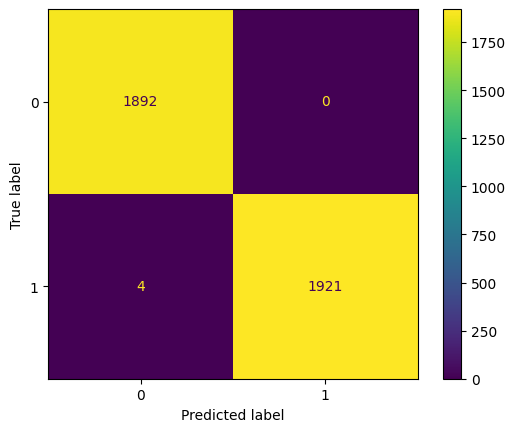

In [120]:
log_cm = confusion_matrix(y_val, y_pred)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.show()

In [121]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



### **XGBoost model**

In [122]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }
scoring = {'recall': 'recall',
    'f1': 'f1',
    'precision': 'precision',
    'accuracy': 'accuracy'}
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [123]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: total: 13min 46s
Wall time: 1min 51s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [124]:
xgb_cv.best_score_

0.9913708291794634

In [125]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 300}

In [126]:
y_pred = xgb_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

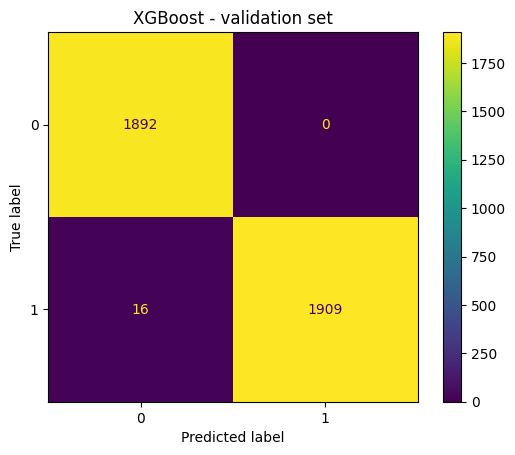

In [127]:
log_cm = confusion_matrix(y_val, y_pred)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
log_disp.plot()
plt.title('XGBoost - validation set');
plt.show()

In [128]:
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1892
       claim       1.00      0.99      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

